In [31]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import  ImageDataGenerator, img_to_array, image, load_img
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.models import load_model
from keras.models import Model
import keras

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

#Variable defining
SAMPLE_PER_CATEGORY = 200
DISEASE = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = 'D:/Datasets/Plant Diseases Dataset/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [32]:
CATEGORIES = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',
              'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
              'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

10

In [33]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Tomato___Bacterial_spot 1484 images
Tomato___Early_blight 1680 images
Tomato___healthy 1694 images
Tomato___Late_blight 1624 images
Tomato___Leaf_Mold 1652 images
Tomato___Septoria_leaf_spot 1526 images
Tomato___Spider_mites Two-spotted_spider_mite 1498 images
Tomato___Target_Spot 1596 images
Tomato___Tomato_mosaic_virus 1568 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus 1708 images


In [34]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size) ## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img
    img = image.img_to_array(img)
    return img

In [35]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(16030, 3)

In [36]:
train.head(2)

,file,category_id,category
0,train/Tomato___Bacterial_spot/00416648-be6e-4b...,0,Tomato___Bacterial_spot
1,train/Tomato___Bacterial_spot/0045ba29-ed1b-43...,0,Tomato___Bacterial_spot


In [37]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape

(2000, 3)

In [38]:
train

,file,category_id,category
0,train/Tomato___Tomato_mosaic_virus/12f82f12-23...,8,Tomato___Tomato_mosaic_virus
1,train/Tomato___Tomato_mosaic_virus/0c676b36-79...,8,Tomato___Tomato_mosaic_virus
2,train/Tomato___Septoria_leaf_spot/0a70601b-851...,5,Tomato___Septoria_leaf_spot
3,train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus
4,train/Tomato___Tomato_mosaic_virus/0a7cc59f-b2...,8,Tomato___Tomato_mosaic_virus
...,...,...,...
1995,train/Tomato___Tomato_mosaic_virus/17964172-e3...,8,Tomato___Tomato_mosaic_virus
1996,train/Tomato___Septoria_leaf_spot/0d8187e2-00e...,5,Tomato___Septoria_leaf_spot
1997,train/Tomato___Early_blight/24379205-969e-4cd0...,1,Tomato___Early_blight
1998,train/Tomato___Bacterial_spot/0045ba29-ed1b-43...,0,Tomato___Bacterial_spot


In [39]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.shape

(10, 2)

In [40]:
test.head(2)

,filepath,file
0,test/Tomato___Bacterial_spot,Tomato___Bacterial_spot
1,test/Tomato___Early_blight,Tomato___Early_blight


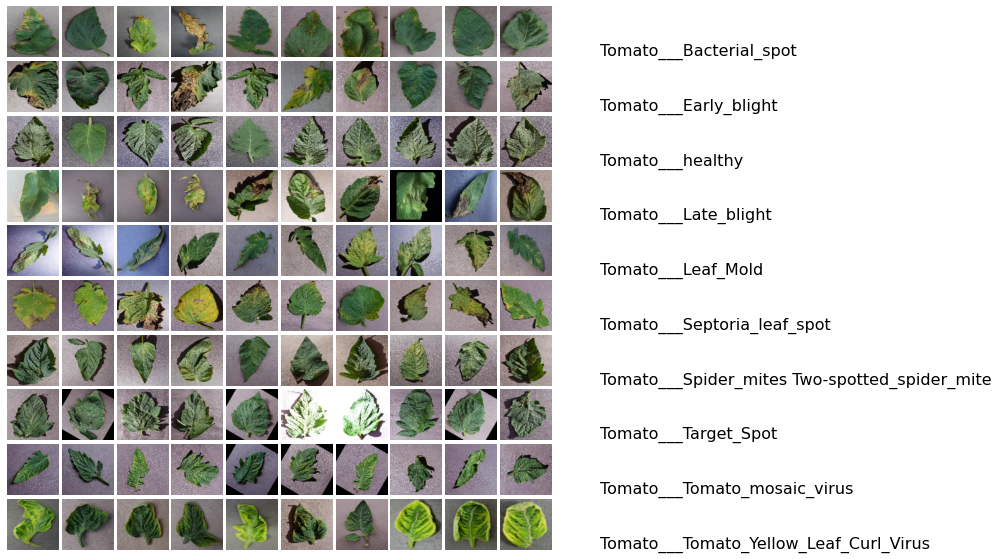

In [41]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [44]:
np.random.seed(seed=DISEASE)

In [45]:
def setTrainableLayersVGG(vgg_model):
    set_trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg_model

In [47]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model = setTrainableLayersVGG(vgg_model)
# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

58900480/58889256 [==============================] - 257s 4us/step


<ipython-input-47-148c5d3ef04f>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001F741A83880>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000001F7448B83D0>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001F744857550>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001F744857EB0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001F744835D90>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001F744828040>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001F74484C9A0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001F7448041C0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001F7447F6250>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001F7447E8DF0>,block3_conv3,False


In [55]:
def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [81]:
#create model from scratch
def createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs):
    print("Create Model")

    tranfer_model = 0 # just define

    if pretrainedModel == "VGG-16":
        tranfer_model = VGG16(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        
        if fineTune == True:
            tranfer_model = setTrainableLayersVGG(tranfer_model)
        else:
            for layer in tranfer_model.layers:
                layer.trainable = False  # freeze feature extracting layers

    output = tranfer_model.layers[-1].output
    output = keras.layers.Flatten()(output)
    trans_model = Model(tranfer_model.input, output)

    model = Sequential()
    model.add(trans_model)
    
    for i in range(0,number_of_hidden_layers):
        model.add(Dense(512))
        model.add(Activation(activation))
        model.add(Dropout(0.3))

    model.add(Dense(10, activation='softmax'))

    if optimizer == 'SGD':
        opt = SGD(lr=learning_rate, decay=learning_rate / epochs)
    elif optimizer == 'Adam':
        opt = Adam(lr=learning_rate, decay=learning_rate / epochs)

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [82]:
#callbacks for keras modal
def get_callbacks(patience):
    print("Get Callbacks")

    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=1e-5, patience=patience, verbose=1)
    #msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, EarlyStopping()]

In [86]:
def trainModelDF(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, cross_validation_folds, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255)
    
    datagen_valid = ImageDataGenerator(rescale=1./255)
        
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.category_id
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")
        
        model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)

        print("======================================")
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="D:/Datasets/Plant Diseases Dataset/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=DISEASE,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="D:/Datasets/Plant Diseases Dataset/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=DISEASE,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

#Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit_generator(generator=train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)#, \
#                             callbacks = get_callbacks(patience=2))
        
        scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, pretrainedModel, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std

In [87]:
#callbacks for keras modal
def get_callbacks(patience):
    print("Get Callbacks")

    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=1e-5, patience=patience, verbose=1)
    #msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, EarlyStopping()]

Train Model
Cross validation
Iteration =  1
Create Model


C:\Users\Sukanya\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-86-3bfc1775b201>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,\


Found 1600 validated image filenames belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Epoch 1/24
50/50 [==============================] - 111s 2s/step - loss: 2.0129 - accuracy: 0.3281 - val_loss: 1.1780 - val_accuracy: 0.6406
Epoch 2/24
50/50 [==============================] - 119s 2s/step - loss: 1.1299 - accuracy: 0.6150 - val_loss: 0.8740 - val_accuracy: 0.7135
Epoch 3/24
50/50 [==============================] - 115s 2s/step - loss: 0.7805 - accuracy: 0.7419 - val_loss: 0.7004 - val_accuracy: 0.7812
Epoch 4/24
50/50 [==============================] - 115s 2s/step - loss: 0.6503 - accuracy: 0.7750 - val_loss: 0.6330 - val_accuracy: 0.7917
Epoch 5/24
50/50 [==============================] - 116s 2s/step - loss: 0.4863 - accuracy: 0.8381 - val_loss: 0.6575 - val_accuracy: 0.7969
Epoch 6/24
50/50 [==============================] - 117s 2s/step - loss: 0.4440 - accuracy: 0.8487 - val_loss: 0.6983 - val_accuracy: 0.7865
Epoch 7/24
50/50 [=============

<ipython-input-86-3bfc1775b201>:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)


Accuarcy accuracy: 82.29%
Iteration =  2
Create Model


C:\Users\Sukanya\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-86-3bfc1775b201>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,\


Found 1600 validated image filenames belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Epoch 1/24
50/50 [==============================] - 115s 2s/step - loss: 1.9332 - accuracy: 0.3487 - val_loss: 1.1621 - val_accuracy: 0.6354
Epoch 2/24
50/50 [==============================] - 114s 2s/step - loss: 1.1019 - accuracy: 0.6319 - val_loss: 0.8824 - val_accuracy: 0.6693
Epoch 3/24
50/50 [==============================] - 1696s 35s/step - loss: 0.8065 - accuracy: 0.7212 - val_loss: 0.7303 - val_accuracy: 0.7552
Epoch 4/24
50/50 [==============================] - 121s 2s/step - loss: 0.6280 - accuracy: 0.7906 - val_loss: 0.7894 - val_accuracy: 0.6901
Epoch 5/24
50/50 [==============================] - 114s 2s/step - loss: 0.5281 - accuracy: 0.8294 - val_loss: 0.7729 - val_accuracy: 0.7240
Epoch 6/24
50/50 [==============================] - 116s 2s/step - loss: 0.3855 - accuracy: 0.8712 - val_loss: 0.6632 - val_accuracy: 0.7604
Epoch 7/24
50/50 [===========

<ipython-input-86-3bfc1775b201>:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)


Accuarcy accuracy: 79.17%
Iteration =  3
Create Model


C:\Users\Sukanya\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-86-3bfc1775b201>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,\


Found 1600 validated image filenames belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Epoch 1/24
50/50 [==============================] - 15722s 321s/step - loss: 2.0261 - accuracy: 0.3237 - val_loss: 1.2843 - val_accuracy: 0.5964
Epoch 2/24
50/50 [==============================] - 127s 3s/step - loss: 1.1221 - accuracy: 0.6175 - val_loss: 0.8585 - val_accuracy: 0.7292
Epoch 3/24
50/50 [==============================] - 117s 2s/step - loss: 0.8240 - accuracy: 0.7163 - val_loss: 0.7509 - val_accuracy: 0.7422
Epoch 4/24
50/50 [==============================] - 119s 2s/step - loss: 0.6430 - accuracy: 0.7800 - val_loss: 0.7340 - val_accuracy: 0.7552
Epoch 5/24
50/50 [==============================] - 117s 2s/step - loss: 0.5746 - accuracy: 0.7994 - val_loss: 0.6657 - val_accuracy: 0.7656
Epoch 6/24
50/50 [==============================] - 117s 2s/step - loss: 0.4121 - accuracy: 0.8644 - val_loss: 0.7708 - val_accuracy: 0.7630
Epoch 7/24
50/50 [=========

<ipython-input-86-3bfc1775b201>:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)


Accuarcy accuracy: 79.95%
Iteration =  4
Create Model


C:\Users\Sukanya\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-86-3bfc1775b201>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,\


Found 1600 validated image filenames belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Epoch 1/24
50/50 [==============================] - 119s 2s/step - loss: 1.9088 - accuracy: 0.3575 - val_loss: 1.1299 - val_accuracy: 0.6562
Epoch 2/24
50/50 [==============================] - 119s 2s/step - loss: 1.0218 - accuracy: 0.6587 - val_loss: 0.8784 - val_accuracy: 0.6953
Epoch 3/24
50/50 [==============================] - 118s 2s/step - loss: 0.7769 - accuracy: 0.7337 - val_loss: 0.7348 - val_accuracy: 0.7682
Epoch 4/24
50/50 [==============================] - 117s 2s/step - loss: 0.6329 - accuracy: 0.7881 - val_loss: 0.7837 - val_accuracy: 0.7370
Epoch 5/24
50/50 [==============================] - 118s 2s/step - loss: 0.4807 - accuracy: 0.8313 - val_loss: 0.7153 - val_accuracy: 0.7708
Epoch 6/24
50/50 [==============================] - 117s 2s/step - loss: 0.4309 - accuracy: 0.8544 - val_loss: 0.6825 - val_accuracy: 0.7891
Epoch 7/24
50/50 [=============

<ipython-input-86-3bfc1775b201>:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)


Accuarcy accuracy: 79.95%
Iteration =  5
Create Model


C:\Users\Sukanya\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-86-3bfc1775b201>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,\


Found 1600 validated image filenames belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Epoch 1/24
50/50 [==============================] - 126s 3s/step - loss: 1.9274 - accuracy: 0.3744 - val_loss: 1.1834 - val_accuracy: 0.6094
Epoch 2/24
50/50 [==============================] - 122s 2s/step - loss: 1.1071 - accuracy: 0.6263 - val_loss: 0.9051 - val_accuracy: 0.7214
Epoch 3/24
50/50 [==============================] - 123s 2s/step - loss: 0.8163 - accuracy: 0.7294 - val_loss: 0.8653 - val_accuracy: 0.7135
Epoch 4/24
50/50 [==============================] - 121s 2s/step - loss: 0.6689 - accuracy: 0.7763 - val_loss: 0.7401 - val_accuracy: 0.7526
Epoch 5/24
50/50 [==============================] - 116s 2s/step - loss: 0.4883 - accuracy: 0.8338 - val_loss: 0.6625 - val_accuracy: 0.7682
Epoch 6/24
50/50 [==============================] - 117s 2s/step - loss: 0.3962 - accuracy: 0.8687 - val_loss: 0.6688 - val_accuracy: 0.7917
Epoch 7/24
50/50 [=============

<ipython-input-86-3bfc1775b201>:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)


Accuarcy accuracy: 81.25%
Accuracy: 80.52% (+/- 1.11%)


(80.52083492279053, 1.1097536843621985)

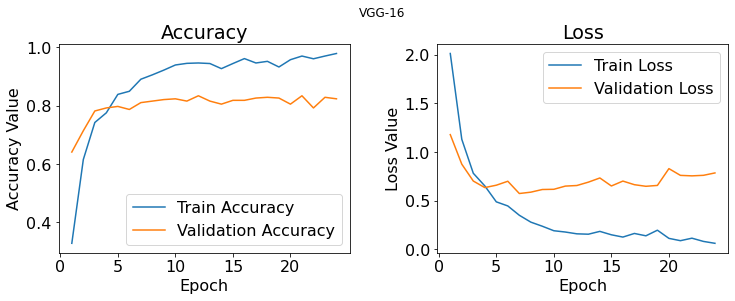

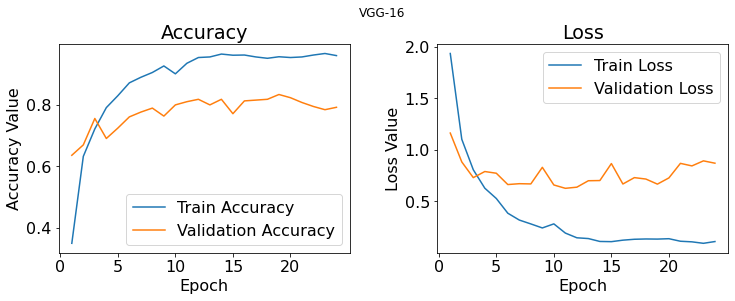

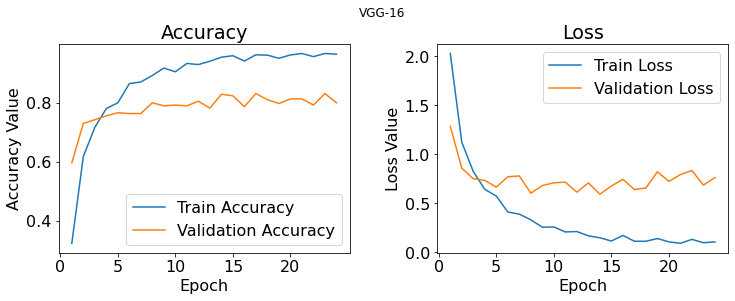

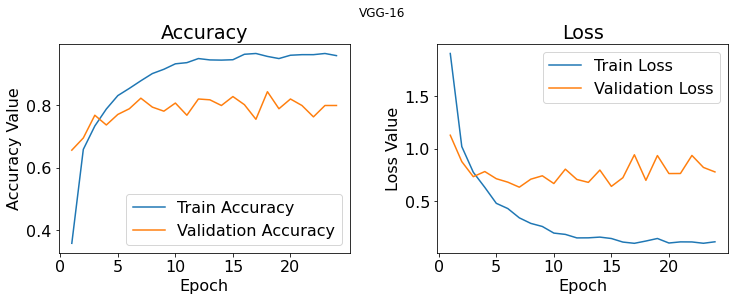

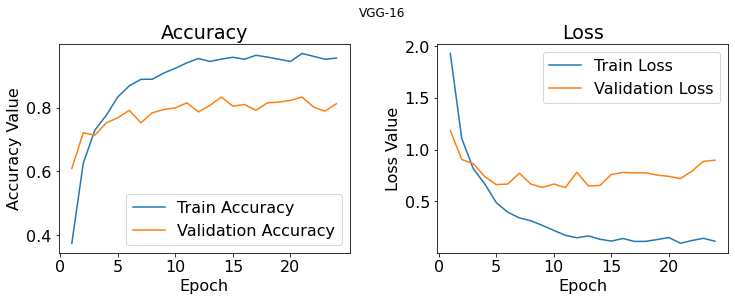

In [89]:
trainModelDF(
    train,
    pretrainedModel = "VGG-16", #ResNet-50
    fineTune = False,
    batch_size =32,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 24
)